In [133]:
library(Matrix)
library(MGMF)
library(lattice)

## Example data

null device 
          1

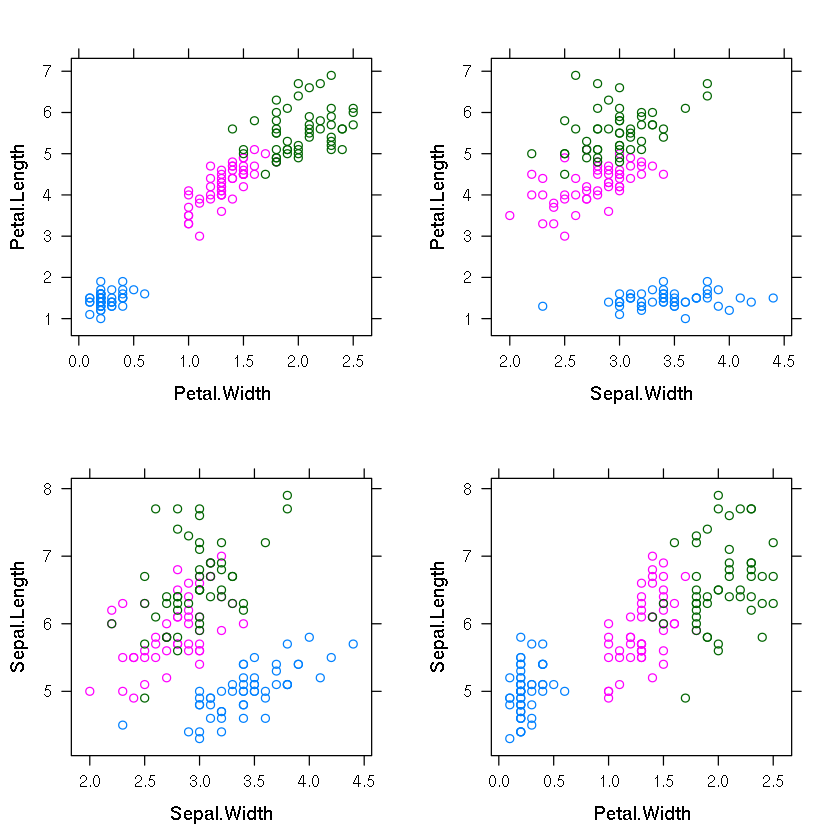

In [2]:
data(iris)
#head(iris)
p1<-xyplot(Sepal.Length~Sepal.Width,data=iris,group=Species)
p2<-xyplot(Petal.Length~Petal.Width,data=iris,group=Species)
p3<-xyplot(Sepal.Length~Petal.Width,data=iris,group=Species)
p4<-xyplot(Petal.Length~Sepal.Width,data=iris,group=Species)
print(p1,c(0,0,0.5,0.5),more=TRUE)
print(p2,c(0,0.5,0.5,1),more=TRUE)
print(p3,c(0.5,0,1,0.5),more=TRUE)
print(p4,c(0.5,0.5,1,1),more=FALSE)
dev.off()

#MGMF Model

Mixture Gaussian Markov Fields uses EM algorithm to maximize the log-likelihood of a following distribution:

$$\prod_n 
\left[  
\sqrt{\frac{\tau_i}{2\pi}}^{s_{j,k}} 
\exp{\left(-\frac{1}{2} s_{j,k} \tau_i \left[ L_n(x,a) \right]^2 \right)} 
\right]
\cdot  \prod_i \Gamma\left(\tau_i,\Omega_{\tau_i}\right) 
\cdot \prod_j \text{Categorical}\left(s_{j,\cdot}, p_l \right)
\cdot \prod_l \text{Dirichlet}\left(p_l,\hat{p}_l\right)
$$
where 
* $s_{j,\cdot}$ is a vector variable distributed by Categorical distribution with probabilities $p_l$ from prior Dirichlet distributions
* $\tau_i$ are precision variables with prior distribution Gamma
* $L_n(x,a)$  are linear functions of data $x$ and latent variables $a$


#Model declaration

In [326]:
#Create a new Mixture Gaussian Markov Fields model
model<-newMGMFmodel()

Declare **data** $x$ as $n$ values of 4 properties.<br>
Organize data variables into 4 columns,
each corresponding to values in 4 dimensions: "Sepal.Length","Sepal.Width","Petal.Length","Petal.Width".
<br>
Each column corresponds to a vector of $n=$NROW(iris) data points.

In [327]:
columns<-c("Sepal.Length","Sepal.Width","Petal.Length","Petal.Width")
df<-data.frame(i=1:NROW(iris))
for (col in columns){
    df[,col]<-model$newData(iris[,col])
}

Declare **latent variables:** $m_{k,\text{col}}$ cluster means. <br>
In each of 4 columns we define K variables, each corresponding to a cluster mean.

Also declare **precisions:** $\tau_{k,\text{col}}$ with which data is distributed around means. <br>
For each cluster and each column define a precision with prior distribution $\Gamma\left(1,1/\text{prec}_0\right)$

In [328]:
K<-3
m<-data.frame(k=1:K)
for (col in columns){
    m[,col]<-model$newVariable(n=K)
}
prec<-data.frame(k=1:K)
for (col in columns){
    sdev<-sd(iris[,col])/K
    precision<-1/sdev^2   
    prec[,col]<-model$newPrecision(gamma.prior=matrix(c(1,1/precision),nrow=2,ncol=K))
}

Declare **means prior data:** $m^{\text{prior}}_{k,\text{col}}$ as quantiles of data in each column.

Declare **precisions for prior means:** $\tau^{\text{prior}}_{\text{col}}$ with which means are distributed around mean.priors, one for each column.

In [329]:
m.prior<-data.frame(k=1:K)
for (col in columns){
    m.prior[,col]<-model$newData(quantile(iris[,col],c(1/6,3/6,5/6)))    
}
prec.prior<-data.frame(i=1)
for (col in columns){
    sdev<-sd(iris[,col])
    precision<-1/sdev^2   
    prec.prior[,col]<-model$newPrecision(const=precision)
}

Declare **categorical distribution** $p$ for the number of cases in each of K clusters, with even Dirichlet prior.

Declare $n$ **indicator variables:** $s_{i,k}$ coming from the above categorical distribution, each indicating the probability of being in the cluster $k$.

In [330]:
#Indicator variables with prior
p<-model$newCategorical(dirichlet.prior=rep(1,K)/K)
ind<-model$newIndicator(p,n=NROW(iris))
#Now ind+0 are indicators for the first category(cluster), ind+1 for the second category, and so on.

Declare **indicator variables** $s^{\text{prior}}_{k,col, \cdot}$ for prior mixture distribution of cluster means. Each distributed with categorical distribution on $K$ categories, with assymetric priors.

In [331]:
#Indicator variables with prior
p.prior<-data.frame(k=1:K)
ind.prior<-data.frame(k=1:K)
for (col in columns){
 dir.prior<-c()
 for (k in 1:K) {
    pvec<-rep(10,K)
    pvec[k]<-pvec[k]+1 # breaking the symmetry
    pvec<-pvec/sum(pvec)  
    dir.prior<-cbind(dir.prior,pvec)
 }
 p.prior[,col]<-model$newCategorical(dirichlet.prior=dir.prior) 
 for (k in 1:K) 
    ind.prior[k,col]<-model$newIndicator(p.prior[k,col],n=1)
}
#Now ind+0 are indicators for the first category(cluster), ind+1 for the second category, and so on.

After everything is declared we may now define the MGMF model by declaring **linear functions**: difference between data and cluster means, and link them with corresponding precisions and indicators. <br>

$$ \prod_{\text{col} \in 1..4,\, k\in 1..K,\, i \in 1..N}
\sqrt{\frac{\tau_{k,\text{col}}}{2\pi}}^{s_{i,k}} 
\exp{\left(-\frac{1}{2} s_{i,k} \tau_{k,\text{col}} \left[ x_{i,\text{col}} - m_{k,\text{col}} \right]^2 \right)} 
$$

In [332]:
#Link means with data: data is normally distributed around means
for (col in columns)
    for (k in 1:K){
        #We define NROW(df) linear functions at once, each is a difference between data and mean
        l<-model$newLinElem(variables=c(df[,col],rep(m[k,col],NROW(df))),
                            columns=c(1:NROW(df),1:NROW(df)),
                            coefficients=c(rep(1,NROW(df)),rep(-1,NROW(df))),
                            indicators=ind+(k-1),
                            precisions=prec[k,col])
}

Declare **linear functions** corresponding to difference between mean priors and cluster means. <br>

$$ \prod_{\text{col} \in 1..4,\, k\in 1..K}
\sqrt{\frac{\tau^{\text{prior}}_{\text{col}}}{2\pi}}^{\sum_{j=1 \ldots K} s^{\text{prior}}_{k,col}}
\exp{\left(-\frac{1}{2} \tau^{\text{prior}}_{\text{col}} 
\sum_{j=1 \ldots K} s^{\text{prior}}_{k,col,j} \left[ m_{k,\text{col}} - m^{\text{prior}}_{j,\text{col}} \right]^2 
\right)} 
$$

In [333]:
#Link means with mean.priors: means are normally distributed around means.prior
for (col in columns) {     
    for (k in 1:K) {
    #We define K linear functions at once, each is a difference between prior mean and mean    
        l<-model$newLinElem(variables=c(m.prior[,col],rep(m[k,col],K)),
                        columns=c(1:K,1:K),
                        coefficients=c(rep(1,K),rep(-1,K)),
                        indicators=ind.prior[k,col]:(ind.prior[k,col]+K-1), #constant 1 instead of indicators
                        precisions=prec.prior[1,col])
    }
}


#Estimate Maximal Likelihood with EM algorithm

In [334]:
#Run EM algorithm on the model
system.time(
    model$runEM()
)

[1] "EM loop: 10"
prec.sumdiff prec.maxdiff  cat.sumdiff  cat.maxdiff 
 29.51479566  10.91120819   0.67348590   0.04054043 
[1] "EM loop: 20"
prec.sumdiff prec.maxdiff  cat.sumdiff  cat.maxdiff 
 0.200951789  0.060414200  0.008503249  0.001207079 
[1] "EM loop: 30"
prec.sumdiff prec.maxdiff  cat.sumdiff  cat.maxdiff 
 0.078260683  0.025338363  0.002903475  0.000438821 
[1] "EM loop: 40"
prec.sumdiff prec.maxdiff  cat.sumdiff  cat.maxdiff 
0.0309628590 0.0104555439 0.0011052758 0.0001690168 
[1] "EM loop: 50"
prec.sumdiff prec.maxdiff  cat.sumdiff  cat.maxdiff 
1.233049e-02 4.231282e-03 4.339729e-04 6.659449e-05 
[1] "EM loop: 60"
prec.sumdiff prec.maxdiff  cat.sumdiff  cat.maxdiff 
4.922551e-03 1.699963e-03 1.723101e-04 2.647281e-05 
[1] "EM loop: 70"
prec.sumdiff prec.maxdiff  cat.sumdiff  cat.maxdiff 
1.967040e-03 6.810206e-04 6.870551e-05 1.056050e-05 
[1] "EM loop: 80"
prec.sumdiff prec.maxdiff  cat.sumdiff  cat.maxdiff 
7.863191e-04 2.725111e-04 2.744105e-05 4.218665e-06 
[1] "EM 

   user  system elapsed 
  2.880   0.000   2.888 

#Analyse clustering results

In [335]:
#Check the clustering performance, assuming assignment when indicator variable is >acc==0.5
acc<-0.5
clust.factor<-factor(1*as.integer(model$getEnv()$indicator[ind+0]>acc)+
                     2*as.integer(model$getEnv()$indicator[ind+1]>acc)+
                     3*as.integer(model$getEnv()$indicator[ind+2]>acc))
#summary(clust.factor)
#summary(interaction(iris$Species,clust.factor))
table(iris$Species,clust.factor)

            clust.factor
              1  2  3
  setosa     50  0  0
  versicolor  0 44  6
  virginica   0  2 48

In [132]:
## Estimated model variables can be accessed using
#model$getEnv()$dataAndVar[df[1,2]]
#model$getEnv()$precision[prec[2,3]]
#model$getEnv()$indicator[ind+1]

In [340]:
p.prior[,columns[1]]
ft<-model$getEnv()$categoricalFromTo[,p.prior[,columns[2]]]

rbind(
model$getEnv()$categorical[ft[1,1]:ft[2,1]],
model$getEnv()$categorical[ft[1,2]:ft[2,2]],
model$getEnv()$categorical[ft[1,3]:ft[2,3]])

[1] 2 3 4

0.2138790,0.2795918,0.5065292
0.4480096,0.3586339,0.1933566
0.2997646,0.4058800,0.2943554


In [282]:
model$getEnv()$dataAndVar[m[1,columns[1]]]-model$getEnv()$dataAndVar[m.prior[1,columns[1]]]
model$getEnv()$dataAndVar[m[2,columns[1]]]-model$getEnv()$dataAndVar[m.prior[2,columns[1]]]
model$getEnv()$dataAndVar[m[3,columns[1]]]-model$getEnv()$dataAndVar[m.prior[3,columns[1]]]
model$getEnv()$dataAndVar[m[1,columns[2]]]-model$getEnv()$dataAndVar[m.prior[1,columns[2]]]
model$getEnv()$dataAndVar[m[2,columns[2]]]-model$getEnv()$dataAndVar[m.prior[2,columns[2]]]
model$getEnv()$dataAndVar[m[3,columns[2]]]-model$getEnv()$dataAndVar[m.prior[3,columns[2]]]
model$getEnv()$dataAndVar[m[1,columns[3]]]-model$getEnv()$dataAndVar[m.prior[1,columns[3]]]
model$getEnv()$dataAndVar[m[2,columns[3]]]-model$getEnv()$dataAndVar[m.prior[2,columns[3]]]
model$getEnv()$dataAndVar[m[3,columns[3]]]-model$getEnv()$dataAndVar[m.prior[3,columns[3]]]
model$getEnv()$dataAndVar[m[1,columns[4]]]-model$getEnv()$dataAndVar[m.prior[1,columns[4]]]
model$getEnv()$dataAndVar[m[2,columns[4]]]-model$getEnv()$dataAndVar[m.prior[2,columns[4]]]
model$getEnv()$dataAndVar[m[3,columns[4]]]-model$getEnv()$dataAndVar[m.prior[3,columns[4]]]
model$getEnv()$dataAndVar[df[,columns[4]]]-iris[,columns[4]]

0.006552295

0.03398373

-0.0755561

0.7254796

-0.2987028

-0.3977083

-0.0379373

-0.123352

-0.03399363

0.04602954

0.005861364

-0.009960339

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
                                                                                
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
                                                                                
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
                                                            
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

null device 
          1

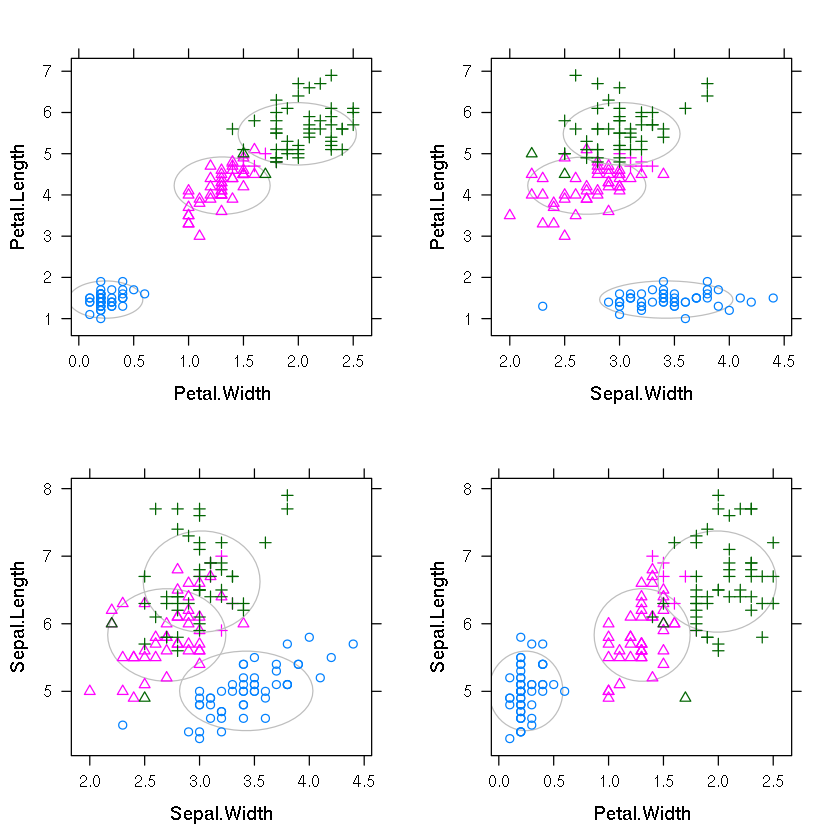

In [281]:
#Clustering performance plot with ellipses indicating fitted Gaussian distributions

give.ellipse<-function(shape,center){
    angles <- seq(0, 2 * pi, length.out = 50 + 1)
    unit.circle <- cbind(cos(angles), sin(angles))
    t(center + 1 * t(unit.circle %*% chol(shape)))
}

iris.xyplot<-function(frm)xyplot(frm,data=iris,group=Species,
        panel=function(...){           
           mypanel.xyplot<-function(x,y,subscripts,type,pch,col,group.number,group.value,
                                    col.line,col.symbol,lty,...){
               #print(group.number)
               col1<-as.character(as.list(frm)[[2]])
               col2<-as.character(as.list(frm)[[3]])
               center<-c(model$getEnv()$dataAndVar[m[group.number,col2]],
                         model$getEnv()$dataAndVar[m[group.number,col1]])
               precision<-c(model$getEnv()$precision[prec[group.number,col2]],
                         model$getEnv()$precision[prec[group.number,col1]])
               sdev<-sqrt(1/precision)
               shape<-matrix(c(sdev[1],0,0,sdev[2]),ncol=2)               
               ell<-give.ellipse(shape,center)
               panel.xyplot(ell[, 1], ell[, 2], type = "l",col="gray")               
               panel.xyplot(x,y,subscripts=subscripts,type=type,
                                pch=clust.factor[subscripts],
                                col.symbol=col.symbol,
                                 ...)
               
          }
          panel.superpose(..., panel.groups=mypanel.xyplot)           
       }                                     
)
p1<-iris.xyplot(Sepal.Length~Sepal.Width)    
p2<-iris.xyplot(Petal.Length~Petal.Width)    
p3<-iris.xyplot(Sepal.Length~Petal.Width)    
p4<-iris.xyplot(Petal.Length~Sepal.Width)        
print(p1,c(0,0,0.5,0.5),more=TRUE)
print(p2,c(0,0.5,0.5,1),more=TRUE)
print(p3,c(0.5,0,1,0.5),more=TRUE)
print(p4,c(0.5,0.5,1,1),more=FALSE)
dev.off()